In [1]:
import numpy as np
import pandas as pd
import os
import scipy 
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline
import matplotlib.pyplot as plt

from pyfrac.visualisation.plotting_support import explode_volume

In [2]:
# PANCAKE MODEL FROM: https://zenodo.org/records/4574249
mod_outpath = '/home/birniece/Documents/data/ToC2ME/VelocityModels'
vmod_file = '/home/birniece/Documents/data/ToC2ME/VelocityModels/ToC2MEVelModel.mat'

In [3]:
mod_zprofile = scipy.io.loadmat(vmod_file)
mod_zprofile.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Mar  2 10:54:39 2021'), ('__version__', '1.0'), ('__globals__', []), ('rho', array([[2400],
       [2400],
       [2400],
       ...,
       [2700],
       [2700],
       [2700]], dtype=uint16)), ('vp', array([[2500.     ],
       [2500.     ],
       [2500.     ],
       ...,
       [4888.76343],
       [4888.76343],
       [4888.76343]])), ('vs', array([[1250.        ],
       [1250.        ],
       [1250.        ],
       ...,
       [2758.16173352],
       [2758.16173352],
       [2758.16173352]])), ('z', array([[   0],
       [   1],
       [   2],
       ...,
       [5998],
       [5999],
       [6000]], dtype=uint16))])

6001 6001


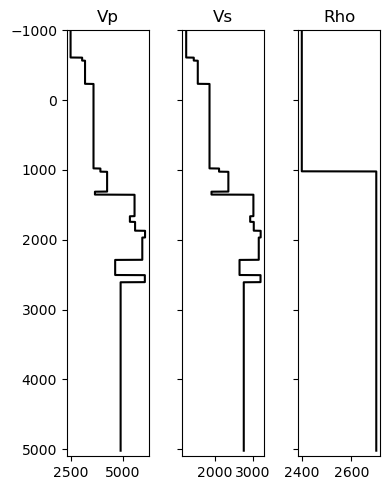

In [4]:
datum = -980
z = mod_zprofile['z'] + datum
vp_1D = mod_zprofile['vp']
vs_1D = mod_zprofile['vs']
rho_1D = mod_zprofile['rho']

print(len(z), len(vp_1D))
fig,axs = plt.subplots(1,3,figsize=[4,5], sharey=True)
axs[0].plot(vp_1D, z,'k')
axs[1].plot(vs_1D, z,'k')
axs[2].plot(rho_1D, z,'k')

axs[0].set_title('Vp')
axs[1].set_title('Vs')
axs[2].set_title('Rho')

for ax in axs:ax.set_ylim(5100,-1000)
fig.tight_layout()

In [11]:
print(vp_1D.min(),vp_1D.mean(),vp_1D.max())

2500.0 4464.6218214580895 6055.14252


---------------------

# Geometry
rec file from : https://github.com/ToC2ME/ToC2ME/blob/master/Rodriguez-Pradilla/LinEpiLoc_ToC2ME_Demo/ToC2ME_Demo_recloc.txt\

    Receivers' location from the Shallow-Borehole monitoring array
    "NL" network code in IRIS database
    Relative coordinates in metres
    Input File: ToC2ME_Demo_recloc.txt 

In [5]:
rec_file = '/home/birniece/Documents/data/ToC2ME/Receivers/ToC2ME_Demo_recloc.txt'

In [6]:
recDF = pd.read_csv(rec_file)
recDF.head()

,StationName,NAD83_X_m,NAD83_Y_m,z_m,DrillDepth_m,LoadedDepth_m
0,1,3422.9603,2117.611,919.293356,27,27
1,2,4288.1870,2072.621,908.303961,27,27
2,3,6782.7966,2903.516,900.890654,27,24
3,4,3235.7770,2588.658,923.843327,27,27
4,5,3700.0376,3062.286,911.115825,27,27


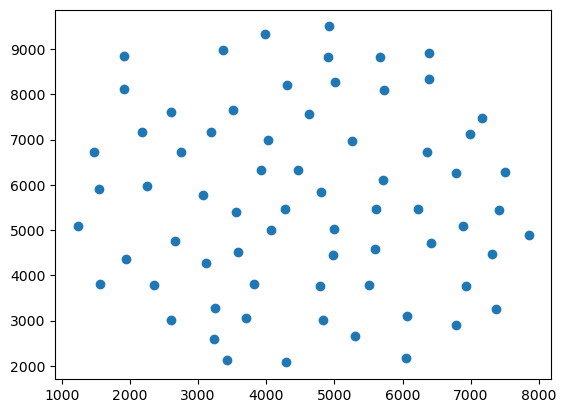

In [7]:
plt.scatter(x=recDF['NAD83_X_m'],
            y=recDF['NAD83_Y_m'])

In [8]:
# determine lateral model extents from 
xmin = min(recDF['NAD83_X_m'])
xmax = max(recDF['NAD83_X_m'])
print('X', xmin, xmax)

ymin = min(recDF['NAD83_Y_m'])
ymax = max(recDF['NAD83_Y_m'])
print('Y', ymin, ymax)

zmin = min(recDF['z_m'])
zmax = max(recDF['z_m'])
print('Z', zmin, zmax)

X 1234.56709999999 7849.87270000001
Y 2072.62100000028 9502.92899999954
Z 816.2254735 971.0501945


# MAKE MODEL

In [9]:
d_xyz = 5 # 10 meter sampling
nbounds = 30

mod_bounds = d_xyz + (d_xyz * nbounds)

mod_xmin = np.round(xmin,decimals=-1) - mod_bounds
mod_xmax = np.round(xmax,decimals=-1) + mod_bounds

mod_ymin = np.round(ymin,decimals=-1) - mod_bounds
mod_ymax = np.round(ymax,decimals=-1) + mod_bounds

mod_zmin = datum
mod_zmax = 4000 + mod_bounds  # based on catalogue 

In [10]:
print(mod_xmin, mod_ymin, mod_zmin, )

1075.0 1915.0 -980


In [11]:
mod_x = np.arange(mod_xmin, mod_xmax + 4*d_xyz, d_xyz)
mod_y = np.arange(mod_ymin, mod_ymax+ 2*d_xyz, d_xyz)
mod_z = np.arange(mod_zmin, mod_zmax+ 3*d_xyz, d_xyz)

nx_mod = len(mod_x)
ny_mod = len(mod_y)
nz_mod = len(mod_z)

In [12]:
print(len(mod_x), len(mod_y), len(mod_z))

1390 1550 1030


In [13]:
z.shape

(6001, 1)

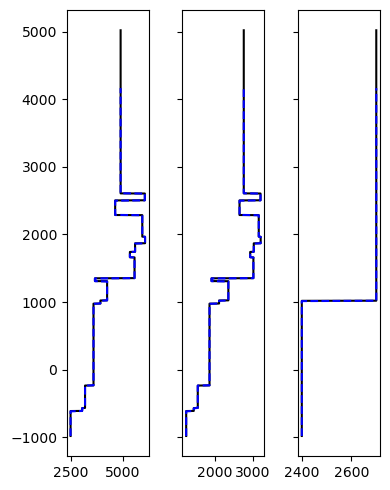

In [14]:
f_vp = scipy.interpolate.interp1d(z.flatten(), vp_1D.flatten(), kind='previous')
f_vs = scipy.interpolate.interp1d(z.flatten(), vs_1D.flatten(), kind='linear')#, kind='previous')
f_rho = scipy.interpolate.interp1d(z.flatten(), rho_1D.flatten(), kind='linear')#, kind='previous')

vp_log = f_vp(mod_z)
vs_log = f_vs(mod_z)
rho_log = f_rho(mod_z)

fig,axs = plt.subplots(1,3,figsize=[4,5], sharey=True)
axs[0].plot(vp_1D, z,'k')
axs[0].plot(vp_log, mod_z, '--b')
axs[1].plot(vs_1D, z,'k')
axs[1].plot(vs_log, mod_z, '--b')
axs[2].plot(rho_1D, z,'k')
axs[2].plot(rho_log, mod_z, '--b')
fig.tight_layout()

In [15]:
# Write as binary
expname = 'ToC2ME_lateralhomo_XYZ_%im'%d_xyz
outpath = os.path.join(mod_outpath,'lateralhomo/')
os.makedirs(outpath, exist_ok=True)

In [16]:
# Expand to 3D
vp_pancake = np.expand_dims(vp_log, axis=[1,2])
vp_pancake = vp_pancake.repeat(nx_mod,axis=2).repeat(ny_mod,axis=1)
print(vp_pancake.shape)
vp_pancake.transpose([2,1,0]).astype(np.float32).tofile(os.path.join(outpath,'%s.vp'%expname),format='<f')
del vp_pancake

vs_pancake = np.expand_dims(vs_log, axis=[1,2])
vs_pancake = vs_pancake.repeat(nx_mod,axis=2).repeat(ny_mod,axis=1)
vs_pancake.transpose([2,1,0]).astype(np.float32).tofile(os.path.join(outpath,'%s.vs'%expname),format='<f')
del vs_pancake

rho_pancake = np.expand_dims(rho_log, axis=[1,2])
rho_pancake = rho_pancake.repeat(nx_mod,axis=2).repeat(ny_mod,axis=1)

rho_pancake.transpose([2,1,0]).astype(np.float32).tofile(os.path.join(outpath,'%s.rho'%expname),format='<f')
del rho_pancake

(1030, 1550, 1390)
